In [1]:
%matplotlib inline


Regions extraction using Dictionary Learning and functional connectomes
=======================================================================

This example shows how to use :class:`nilearn.regions.RegionExtractor`
to extract spatially constrained brain regions from whole brain maps decomposed
using dictionary learning and use them to build a functional connectome.

We used 20 resting state ADHD functional datasets from :func:`nilearn.datasets.fetch_adhd`
and :class:`nilearn.decomposition.DictLearning` for set of brain atlas maps.

This example can also be inspired to apply the same steps to even regions extraction
using ICA maps. In that case, idea would be to replace dictionary learning to canonical
ICA decomposition using :class:`nilearn.decomposition.CanICA`

Please see the related documentation of :class:`nilearn.regions.RegionExtractor`
for more details.

<div class="alert alert-info"><h4>Note</h4><p>The use of the attribute `components_img_` from dictionary learning
    estimator is implemented from version 0.4.1. For older versions,
    unmask the deprecated attribute `components_` to get the components
    image using attribute `masker_` embedded in estimator.
    See the `section Inverse transform: unmasking data <unmasking_step>`.</p></div>



Fetch ADHD resting state functional datasets
---------------------------------------------

We use nilearn's datasets downloading utilities



In [2]:
from nilearn import datasets

adhd_dataset = datasets.fetch_adhd(n_subjects=20)
func_filenames = adhd_dataset.func
confounds = adhd_dataset.confounds

/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/nilearn/datasets/func.py:503: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)


Extract resting-state networks with DictionaryLearning
-------------------------------------------------------



/Users/poldrack/anaconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/poldrack/anaconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: Import

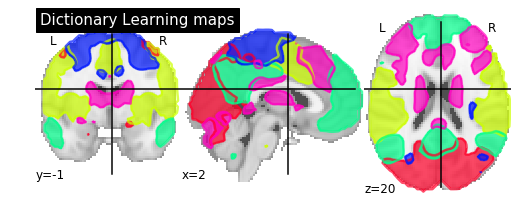

In [3]:
# Import dictionary learning algorithm from decomposition module and call the
# object and fit the model to the functional datasets
from nilearn.decomposition import DictLearning

# Initialize DictLearning object
dict_learn = DictLearning(n_components=5, smoothing_fwhm=6.,
                          memory="nilearn_cache", memory_level=2,
                          random_state=0)
# Fit to the data
dict_learn.fit(func_filenames)
# Resting state networks/maps in attribute `components_img_`
# Note that this attribute is implemented from version 0.4.1.
# For older versions, see the note section above for details.
components_img = dict_learn.components_img_

# Visualization of resting state networks
# Show networks using plotting utilities
from nilearn import plotting

plotting.plot_prob_atlas(components_img, view_type='filled_contours',
                         title='Dictionary Learning maps')

Extract regions from networks
------------------------------



/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `a

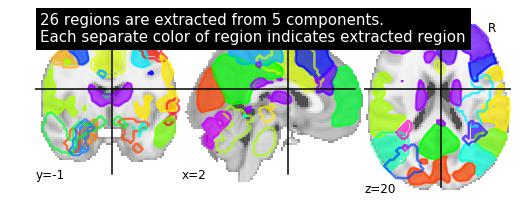

In [4]:
# Import Region Extractor algorithm from regions module
# threshold=0.5 indicates that we keep nominal of amount nonzero voxels across all
# maps, less the threshold means that more intense non-voxels will be survived.
from nilearn.regions import RegionExtractor

extractor = RegionExtractor(components_img, threshold=0.5,
                            thresholding_strategy='ratio_n_voxels',
                            extractor='local_regions',
                            standardize=True, min_region_size=1350)
# Just call fit() to process for regions extraction
extractor.fit()
# Extracted regions are stored in regions_img_
regions_extracted_img = extractor.regions_img_
# Each region index is stored in index_
regions_index = extractor.index_
# Total number of regions extracted
n_regions_extracted = regions_extracted_img.shape[-1]

# Visualization of region extraction results
title = ('%d regions are extracted from %d components.'
         '\nEach separate color of region indicates extracted region'
         % (n_regions_extracted, 5))
plotting.plot_prob_atlas(regions_extracted_img, view_type='filled_contours',
                         title=title)

Compute correlation coefficients
---------------------------------



In [5]:
# First we need to do subjects timeseries signals extraction and then estimating
# correlation matrices on those signals.
# To extract timeseries signals, we call transform() from RegionExtractor object
# onto each subject functional data stored in func_filenames.
# To estimate correlation matrices we import connectome utilities from nilearn
from nilearn.connectome import ConnectivityMeasure

correlations = []
# Initializing ConnectivityMeasure object with kind='correlation'
connectome_measure = ConnectivityMeasure(kind='correlation')
for filename, confound in zip(func_filenames, confounds):
    # call transform from RegionExtractor object to extract timeseries signals
    timeseries_each_subject = extractor.transform(filename, confounds=confound)
    # call fit_transform from ConnectivityMeasure object
    correlation = connectome_measure.fit_transform([timeseries_each_subject])
    # saving each subject correlation to correlations
    correlations.append(correlation)

# Mean of all correlations
import numpy as np
mean_correlations = np.mean(correlations, axis=0).reshape(n_regions_extracted,
                                                          n_regions_extracted)

/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on un

Plot resulting connectomes
----------------------------



/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


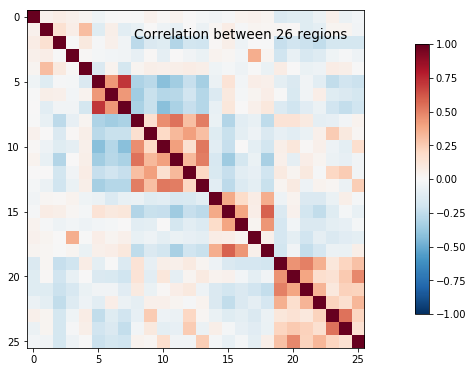

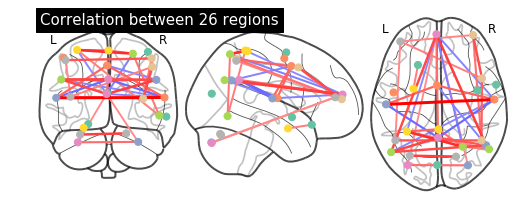

In [6]:
title = 'Correlation between %d regions' % n_regions_extracted

# First plot the matrix
display = plotting.plot_matrix(mean_correlations, vmax=1, vmin=-1,
                               colorbar=True, title=title)

# Then find the center of the regions and plot a connectome
regions_img = regions_extracted_img
coords_connectome = plotting.find_probabilistic_atlas_cut_coords(regions_img)

plotting.plot_connectome(mean_correlations, coords_connectome,
                         edge_threshold='90%', title=title)

Plot regions extracted for only one specific network
----------------------------------------------------



/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


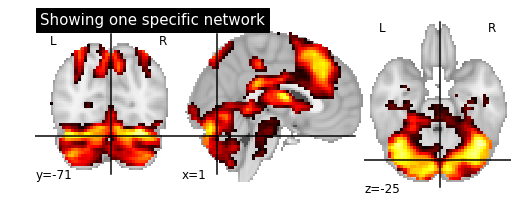

In [7]:
# First, we plot a network of index=4 without region extraction (left plot)
from nilearn import image

img = image.index_img(components_img, 4)
coords = plotting.find_xyz_cut_coords(img)
display = plotting.plot_stat_map(img, cut_coords=coords, colorbar=False,
                                 title='Showing one specific network')

Now, we plot (right side) same network after region extraction to show that
connected regions are nicely seperated.
Each brain extracted region is identified as separate color.



/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/ma/core.py:2785: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


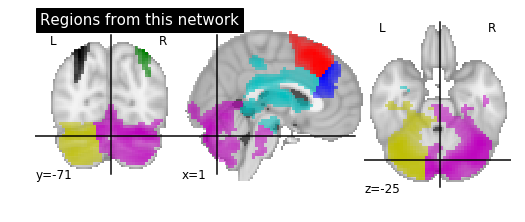

In [8]:
# For this, we take the indices of the all regions extracted related to original
# network given as 4.
regions_indices_of_map3 = np.where(np.array(regions_index) == 4)

display = plotting.plot_anat(cut_coords=coords,
                             title='Regions from this network')

# Add as an overlay all the regions of index 4
colors = 'rgbcmyk'
for each_index_of_map3, color in zip(regions_indices_of_map3[0], colors):
    display.add_overlay(image.index_img(regions_extracted_img, each_index_of_map3),
                        cmap=plotting.cm.alpha_cmap(color))

plotting.show()